# David Stanko
# Education Inequality Project
# Complete Analysis Notebook

## Introduction

The purpose of this notebook is to determine whether students' average ACT scores are predicted by socioeconomic factors. As an additional step, we want to determine whether there is a relationship between average ACT scores and geographic location. We will do this using regression.

## Data sources

One dataset we will use is the EdGap dataset, obtained from [EdGap.org](https://www.edgap.org/#4/37.71/-95.99). The socioeconomic data is from the Census Bureau’s American Community Survey. EdGap.org states that the test score data is from the states' departments of education or another public data release.

Another dataset is the school information dataset, obtained from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp).

Next, we have the state population dataset, which is publicly available census data from the [United States Census Bureau](https://www.census.gov/).

Finally, we will use the zip code dataset from [United States Zip Codes](https://www.unitedstateszipcodes.org/). We will use the personal use version of their dataset.

[This file](https://github.com/David-S-2002/Education-Project/blob/main/David_Stanko_data_preparation_education.ipynb) produced the clean dataset.

## Import libraries

In [1170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Load clean data

##### $\rightarrow$ Load the clean data set from Github.

Previously, we did the train test split in the data preparation notebook. But, since we will be joining new data with the clean dataset, we will load the entire clean dataset, join it with the new data, and then do the train test split again.

We will also have separate train/test sets for answering the "main question" (whether ACT scores are predicted by socioeconomic factors) and for answering the additional analysis question.

In [1171]:
education_df = pd.read_csv("https://raw.githubusercontent.com/David-S-2002/Education-Project/main/education_data.csv", dtype={'zip_code':'str', 'id':'str'})

##### $\rightarrow$ Review the contents of the data set.

In [1172]:
education_df.head()

id  rate_unemployment  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  average_act  percent_lunch     state zip_code  \
0        42820.0    20.433455       0.066901  DELAWARE    19804   
1        89320.0    19.498168       0.112412  DELAWARE    19709   
2        84140.0    19.554335       0.096816  DELAWARE    19709   
3        56500.0    17.737485       0.296960  DELAWARE    19958   
4        54015.0    18.245421       0.262641  DELAWARE    19934   

      school_type school_level  percent_employed  
0  Regular School         High          0.882038  
1  Regular School         High          0.936016  
2  Regular School         High          0.943540  
3  Regular School         High          0.955261  
4  Regular School         High          0.922986

## Convert data types and drop irrelevant variables

percent_employed will probably have a high collinearity with rate_unemployment, so we should drop it. Also, id is irrelevant for prediction.

In [1175]:
education_df.drop(['id', 'percent_employed'], axis='columns', inplace=True)

## Convert categorical data to a numerical representation

We need to do this since the regression methods we are using cannot work with string data.

### Convert the states to numbers from 1 to 50 so that adjacent states have adjacent numbers

Let's see how many states we need to assign numbers to.

In [1176]:
education_df['state'].unique()

array(['DELAWARE', 'FLORIDA', 'GEORGIA', 'ILLINOIS', 'INDIANA',
       'KENTUCKY', 'LOUISIANA', 'MASSACHUSETTS', 'MICHIGAN', 'MISSOURI',
       'NEW JERSEY', 'NEW YORK', 'NORTH CAROLINA', 'OHIO', 'PENNSYLVANIA',
       'TENNESSEE', 'TEXAS', 'WASHINGTON', 'WISCONSIN', 'WYOMING'],
      dtype=object)

We will use the following numbering of the states (we only need to number the states that are in the dataset).

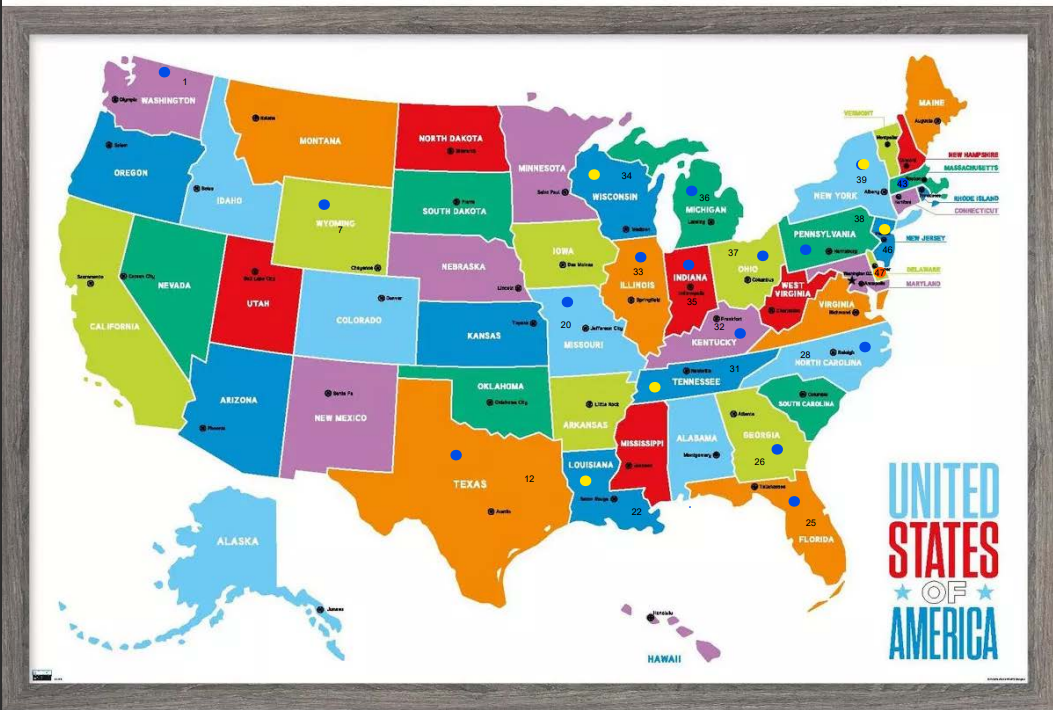

In [1177]:
state_numbers = {'WASHINGTON':1, 'WYOMING':7, "TEXAS":12, 'MISSOURI':20, 'LOUISIANA':22, 'FLORIDA':25, 'GEORGIA':26, 'NORTH CAROLINA':28,\
                 'TENNESSEE':31, 'KENTUCKY':32, 'ILLINOIS':33, 'WISCONSIN':34, 'INDIANA':35, 'MICHIGAN':36, 'OHIO':37, \
                 'PENNSYLVANIA':38, 'NEW YORK':39, 'MASSACHUSETTS':43, 'NEW JERSEY':46, 'DELAWARE':47}
education_df.replace({'state':state_numbers}, inplace=True)
education_df.head()

rate_unemployment  percent_college  percent_married  median_income  \
0           0.117962         0.445283         0.346495        42820.0   
1           0.063984         0.662765         0.767619        89320.0   
2           0.056460         0.701864         0.713090        84140.0   
3           0.044739         0.692062         0.641283        56500.0   
4           0.077014         0.640060         0.834402        54015.0   

   average_act  percent_lunch  state zip_code     school_type school_level  
0    20.433455       0.066901     47    19804  Regular School         High  
1    19.498168       0.112412     47    19709  Regular School         High  
2    19.554335       0.096816     47    19709  Regular School         High  
3    17.737485       0.296960     47    19958  Regular School         High  
4    18.245421       0.262641     47    19934  Regular School         High

### Convert school type and school level to numerical data

In [1178]:
education_df['school_type'].unique()

array(['Regular School', 'Alternative School', 'Special Education School',
       'Career and Technical School'], dtype=object)

In [1179]:
education_df['school_level'].unique()

array(['High', 'Other', 'Not reported', 'Elementary'], dtype=object)

Since there are 4 unique values in each of those columns, we will replace them with integers from 1 to 4.

In [1180]:
school_type_dict = {'Regular School':1, 'Alternative School':2, 'Special Education School':3, 'Career and Technical School':4}
education_df.replace({'school_type':school_type_dict}, inplace=True)

In [1181]:
school_level_dict = {'Elementary':1, 'High':2, 'Other':3, 'Not reported':4}
education_df.replace({'school_level':school_level_dict}, inplace=True)
education_df.head()

rate_unemployment  percent_college  percent_married  median_income  \
0           0.117962         0.445283         0.346495        42820.0   
1           0.063984         0.662765         0.767619        89320.0   
2           0.056460         0.701864         0.713090        84140.0   
3           0.044739         0.692062         0.641283        56500.0   
4           0.077014         0.640060         0.834402        54015.0   

   average_act  percent_lunch  state zip_code  school_type  school_level  
0    20.433455       0.066901     47    19804            1             2  
1    19.498168       0.112412     47    19709            1             2  
2    19.554335       0.096816     47    19709            1             2  
3    17.737485       0.296960     47    19958            1             2  
4    18.245421       0.262641     47    19934            1             2

## Train test split of the data for the main question

Keep 20% of the data for testing.

In [1182]:
train_df, test_df = train_test_split(education_df, test_size=0.2, random_state=1)

In [1183]:
train_df.head()

rate_unemployment  percent_college  percent_married  median_income  \
2943           0.127138         0.453259         0.507042        31403.0   
5337           0.228130         0.304646         0.255024        28438.0   
7263           0.059262         0.335780         0.624696        45134.0   
4912           0.060954         0.537715         0.637829        50689.0   
5377           0.055249         0.575221         0.713514        40247.0   

      average_act  percent_lunch  state zip_code  school_type  school_level  
2943    18.500000       0.346154     36    49868            1             2  
5337    16.733822       0.661538     38    19137            1             3  
7263    18.125763       0.993023      1    98932            1             2  
4912    21.000000       0.309426     37    44047            1             2  
5377    21.446886       0.291139     38    15522            1             2

In [1184]:
test_df.head()

rate_unemployment  percent_college  percent_married  median_income  \
7250           0.108587         0.530511         0.644038        61125.0   
2896           0.105714         0.641236         0.377907        42100.0   
3329           0.095652         0.567254         0.564995        49628.0   
6120           0.150187         0.448336         0.454839        15683.0   
2842           0.111819         0.546375         0.844140        47168.0   

      average_act  percent_lunch  state zip_code  school_type  school_level  
7250    19.884005       0.375635      1    98023            1             2  
2896    19.500000       0.338809     36    49660            1             2  
3329    20.000000       0.376604     20    64119            1             2  
6120    20.400000       0.279687     31    37210            1             2  
2842    19.500000       0.378476     36    48846            1             2

## Normalize the data for the main question

Get the mean and standard deviation of each feature in the training set. Since there's categorical data in the training set, we will

In [1185]:
X_train = train_df.drop("average_act", axis='columns')
Y_train = train_df["average_act"]
X_test = test_df.drop("average_act", axis='columns')
Y_test = test_df["average_act"]

In [1186]:
X_train.head()

rate_unemployment  percent_college  percent_married  median_income  \
2943           0.127138         0.453259         0.507042        31403.0   
5337           0.228130         0.304646         0.255024        28438.0   
7263           0.059262         0.335780         0.624696        45134.0   
4912           0.060954         0.537715         0.637829        50689.0   
5377           0.055249         0.575221         0.713514        40247.0   

      percent_lunch  state zip_code  school_type  school_level  
2943       0.346154     36    49868            1             2  
5337       0.661538     38    19137            1             3  
7263       0.993023      1    98932            1             2  
4912       0.309426     37    44047            1             2  
5377       0.291139     38    15522            1             2

Get the mean and standard deviation of the training set for only the numeric columns

In [1187]:
numerical_cols = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch']
train_mean = X_train[numerical_cols].mean(numeric_only=True)
train_mean

rate_unemployment        0.097919
percent_college          0.569715
percent_married          0.634381
median_income        52122.925158
percent_lunch            0.419234
dtype: float64

In [1188]:
train_sd = X_train[numerical_cols].std(numeric_only=True)
train_sd

rate_unemployment        0.058054
percent_college          0.166395
percent_married          0.195482
median_income        24103.867399
percent_lunch            0.238314
dtype: float64

Normalize the data. Since there is categorical data, we can't subtract or divide categorical data. So, we will make the categorical columns the index so that the subtraction and division doesn't affect those columns.

In [1189]:
X_test = X_test.set_index(['state', 'zip_code', 'school_type', 'school_level'], append=True)
X_test.head()

rate_unemployment  \
     state zip_code school_type school_level                      
7250 1     98023    1           2                      0.108587   
2896 36    49660    1           2                      0.105714   
3329 20    64119    1           2                      0.095652   
6120 31    37210    1           2                      0.150187   
2842 36    48846    1           2                      0.111819   

                                              percent_college  \
     state zip_code school_type school_level                    
7250 1     98023    1           2                    0.530511   
2896 36    49660    1           2                    0.641236   
3329 20    64119    1           2                    0.567254   
6120 31    37210    1           2                    0.448336   
2842 36    48846    1           2                    0.546375   

                                              percent_married  median_income  \
     state zip_code school_type school_level                                   
7250 1     98023    1           2                    0.644038        61125.0   
2896 36    49660    1           2                    0.377907        42100.0   
3329 20    64119    1           2                    0.564995        49628.0   
6120 31    37210    1           2                    0.454839        15683.0   
2842 36    48846    1           2                    0.844140        47168.0   

                                              percent_lunch  
     state zip_code school_type school_level                 
7250 1     98023    1           2                  0.375635  
2896 36    49660    1           2                  0.338809  
3329 20    64119    1           2                  0.376604  
6120 31    37210    1           2                  0.279687  
2842 36    48846    1           2                  0.378476

In [1190]:
X_train = X_train.set_index(['state', 'zip_code', 'school_type', 'school_level'], append=True)
X_train.head()

rate_unemployment  \
     state zip_code school_type school_level                      
2943 36    49868    1           2                      0.127138   
5337 38    19137    1           3                      0.228130   
7263 1     98932    1           2                      0.059262   
4912 37    44047    1           2                      0.060954   
5377 38    15522    1           2                      0.055249   

                                              percent_college  \
     state zip_code school_type school_level                    
2943 36    49868    1           2                    0.453259   
5337 38    19137    1           3                    0.304646   
7263 1     98932    1           2                    0.335780   
4912 37    44047    1           2                    0.537715   
5377 38    15522    1           2                    0.575221   

                                              percent_married  median_income  \
     state zip_code school_type school_level                                   
2943 36    49868    1           2                    0.507042        31403.0   
5337 38    19137    1           3                    0.255024        28438.0   
7263 1     98932    1           2                    0.624696        45134.0   
4912 37    44047    1           2                    0.637829        50689.0   
5377 38    15522    1           2                    0.713514        40247.0   

                                              percent_lunch  
     state zip_code school_type school_level                 
2943 36    49868    1           2                  0.346154  
5337 38    19137    1           3                  0.661538  
7263 1     98932    1           2                  0.993023  
4912 37    44047    1           2                  0.309426  
5377 38    15522    1           2                  0.291139

In [1191]:
X_train_norm = (X_train - train_mean)/train_sd
X_test_norm = (X_test - train_mean)/train_sd

Reset the index to an integer index

In [1192]:
X_test_norm = X_test_norm.reset_index().drop('level_0', axis='columns')
X_test_norm.head()

state zip_code  school_type  school_level  rate_unemployment  \
0      1    98023            1             2           0.183749   
1     36    49660            1             2           0.134268   
2     20    64119            1             2          -0.039055   
3     31    37210            1             2           0.900320   
4     36    48846            1             2           0.239421   

   percent_college  percent_married  median_income  percent_lunch  
0        -0.235604         0.049400       0.373470      -0.182949  
1         0.429826        -1.312010      -0.415822      -0.337474  
2        -0.014791        -0.354949      -0.103507      -0.178881  
3        -0.729461        -0.918460      -1.511787      -0.585556  
4        -0.140265         1.073035      -0.205566      -0.171023

In [1193]:
X_train_norm = X_train_norm.reset_index().drop('level_0', axis='columns')
X_train_norm.head()

state zip_code  school_type  school_level  rate_unemployment  \
0     36    49868            1             2           0.503292   
1     38    19137            1             3           2.242930   
2      1    98932            1             2          -0.665897   
3     37    44047            1             2          -0.636738   
4     38    15522            1             2          -0.735021   

   percent_college  percent_married  median_income  percent_lunch  
0        -0.699877        -0.651410      -0.859610      -0.306654  
1        -1.593011        -1.940624      -0.982619       1.016747  
2        -1.405899        -0.049545      -0.289950       2.407706  
3        -0.192311         0.017637      -0.059489      -0.460768  
4         0.033092         0.404808      -0.492698      -0.537503

## Preparation of the data for the additional analysis question

### Load new data

In [1194]:
zip_code_data = pd.read_csv("https://raw.githubusercontent.com/David-S-2002/Education-Project/main/zip_code_database.csv", dtype={'zip':'str'})

In [1195]:
!wget -O state_populations.csv https://raw.githubusercontent.com/David-S-2002/Education-Project/main/state_populations.csv

--2024-05-07 04:06:13--  https://raw.githubusercontent.com/David-S-2002/Education-Project/main/state_populations.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3802 (3.7K) [text/plain]
Saving to: ‘state_populations.csv’

state_populations.c 100%[===================>]   3.71K  --.-KB/s    in 0s      

2024-05-07 04:06:13 (43.2 MB/s) - ‘state_populations.csv’ saved [3802/3802]



In [1196]:
state_populations = pd.read_csv('state_populations.csv', header=2)
state_populations.head(8)

Geographic Area  April 1, 2020 Estimates Base  \
0             NaN                           NaN   
1   United States                   331449520.0   
2       Northeast                    57609156.0   
3         Midwest                    68985537.0   
4           South                   126266262.0   
5            West                    78588565.0   
6        .Alabama                     5024356.0   
7         .Alaska                      733378.0   

   Population Estimate (as of July 1)   Unnamed: 3   Unnamed: 4  
0                              2020.0       2021.0       2022.0  
1                         331511512.0  332031554.0  333287557.0  
2                          57448898.0   57259257.0   57040406.0  
3                          68961043.0   68836505.0   68787595.0  
4                         126450613.0  127346029.0  128716192.0  
5                          78650958.0   78589763.0   78743364.0  
6                           5031362.0    5049846.0    5074296.0  
7                            732923.0     734182.0     733583.0

Clean up and reformat the headers and column names of the state population DataFrame

In [1197]:
state_populations = state_populations.drop(0, axis='index').rename(columns={'Population Estimate (as of July 1)':'population_july_2020', 'Unnamed: 3':'population_july_2021',	'Unnamed: 4':'population_july_2022'})
state_populations.head()

Geographic Area  April 1, 2020 Estimates Base  population_july_2020  \
1   United States                   331449520.0           331511512.0   
2       Northeast                    57609156.0            57448898.0   
3         Midwest                    68985537.0            68961043.0   
4           South                   126266262.0           126450613.0   
5            West                    78588565.0            78650958.0   

   population_july_2021  population_july_2022  
1           332031554.0           333287557.0  
2            57259257.0            57040406.0  
3            68836505.0            68787595.0  
4           127346029.0           128716192.0  
5            78589763.0            78743364.0

### Explore contents of datasets

In [1198]:
zip_code_data.head()

zip      type  decommissioned primary_city acceptable_cities  \
0  00501    UNIQUE               0   Holtsville               NaN   
1  00544    UNIQUE               0   Holtsville               NaN   
2  00601  STANDARD               0     Adjuntas               NaN   
3  00602  STANDARD               0       Aguada               NaN   
4  00603  STANDARD               0    Aguadilla             Ramey   

                                 unacceptable_cities state  \
0                           Internal Revenue Service    NY   
1                           Internal Revenue Service    NY   
2  Colinas Del Gigante, Jard De Adjuntas, Urb San...    PR   
3  Alts De Aguada, Bo Guaniquilla, Comunidad Las ...    PR   
4  Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...    PR   

                county             timezone area_codes world_region country  \
0       Suffolk County     America/New_York        631          NaN      US   
1       Suffolk County     America/New_York        631          NaN      US   
2   Adjuntas Municipio  America/Puerto_Rico   787, 939          NaN      US   
3     Aguada Municipio  America/Puerto_Rico   787, 939          NaN      US   
4  Aguadilla Municipio  America/Puerto_Rico   787, 939          NaN      US   

   latitude  longitude  irs_estimated_population  
0     40.81     -73.04                       562  
1     40.81     -73.04                         0  
2     18.16     -66.72                         0  
3     18.38     -67.18                         0  
4     18.43     -67.15                         0

In [1199]:
zip_code_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42735 entries, 0 to 42734
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   zip                       42735 non-null  object 
 1   type                      42735 non-null  object 
 2   decommissioned            42735 non-null  int64  
 3   primary_city              42735 non-null  object 
 4   acceptable_cities         9302 non-null   object 
 5   unacceptable_cities       11673 non-null  object 
 6   state                     42735 non-null  object 
 7   county                    41806 non-null  object 
 8   timezone                  41944 non-null  object 
 9   area_codes                41919 non-null  object 
 10  world_region              333 non-null    object 
 11  country                   42657 non-null  object 
 12  latitude                  42735 non-null  float64
 13  longitude                 42735 non-null  float64
 14  irs_es

We will only use the zip and irs_estimated_population columns. There is no missing data for those.

In [1200]:
zip_code_data[["zip", "irs_estimated_population"]].describe()

irs_estimated_population
count              42735.000000
mean                6846.074365
std                12115.762502
min                    0.000000
25%                  286.000000
50%                 1260.000000
75%                 7155.000000
max               128670.000000

In [1201]:
state_populations.head(8)

Geographic Area  April 1, 2020 Estimates Base  population_july_2020  \
1   United States                   331449520.0           331511512.0   
2       Northeast                    57609156.0            57448898.0   
3         Midwest                    68985537.0            68961043.0   
4           South                   126266262.0           126450613.0   
5            West                    78588565.0            78650958.0   
6        .Alabama                     5024356.0             5031362.0   
7         .Alaska                      733378.0              732923.0   
8        .Arizona                     7151507.0             7179943.0   

   population_july_2021  population_july_2022  
1           332031554.0           333287557.0  
2            57259257.0            57040406.0  
3            68836505.0            68787595.0  
4           127346029.0           128716192.0  
5            78589763.0            78743364.0  
6             5049846.0             5074296.0  
7              734182.0              733583.0  
8             7264877.0             7359197.0

In [1202]:
state_populations.tail(8)

Geographic Area  \
56                                           .Wyoming   
57                                                NaN   
58                                       .Puerto Rico   
59  Note: The estimates are developed from a base ...   
60                                Suggested Citation:   
61  Annual Estimates of the Resident Population fo...   
62    Source: U.S. Census Bureau, Population Division   
63                        Release Date: December 2022   

    April 1, 2020 Estimates Base  population_july_2020  population_july_2021  \
56                      576837.0              577605.0              579483.0   
57                           NaN                   NaN                   NaN   
58                     3285874.0             3281557.0             3262693.0   
59                           NaN                   NaN                   NaN   
60                           NaN                   NaN                   NaN   
61                           NaN                   NaN                   NaN   
62                           NaN                   NaN                   NaN   
63                           NaN                   NaN                   NaN   

    population_july_2022  
56              581381.0  
57                   NaN  
58             3221789.0  
59                   NaN  
60                   NaN  
61                   NaN  
62                   NaN  
63                   NaN

The first few rows have the populations of entire regions of the US, which we won't need, so we'll drop those later. The last few rows have information about the data source (instead of data points), so we can drop those too.

In [1203]:
state_populations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 1 to 63
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Geographic Area               62 non-null     object 
 1   April 1, 2020 Estimates Base  57 non-null     float64
 2   population_july_2020          57 non-null     float64
 3   population_july_2021          57 non-null     float64
 4   population_july_2022          57 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.6+ KB


We'll need to convert the populations from floats to ints.

### Convert data types

In [1204]:
zip_code_data.dtypes

zip                          object
type                         object
decommissioned                int64
primary_city                 object
acceptable_cities            object
unacceptable_cities          object
state                        object
county                       object
timezone                     object
area_codes                   object
world_region                 object
country                      object
latitude                    float64
longitude                   float64
irs_estimated_population      int64
dtype: object

In [1205]:
state_populations['April 1, 2020 Estimates Base'] = state_populations['April 1, 2020 Estimates Base'].astype('Int64')
state_populations['population_july_2020'] = state_populations['population_july_2020'].astype('Int64')
state_populations['population_july_2021'] = state_populations['population_july_2021'].astype('Int64')
state_populations['population_july_2022'] = state_populations['population_july_2022'].astype('Int64')

In [1206]:
state_populations.dtypes

Geographic Area                 object
April 1, 2020 Estimates Base     Int64
population_july_2020             Int64
population_july_2021             Int64
population_july_2022             Int64
dtype: object

### Select relevant subsets of data

#### Zip code data

For the zip code dataset, we only need the columns `zip` and `irs_estimated_population`

In [1207]:
zip_code_data = zip_code_data[["zip", "irs_estimated_population"]]

We will only use the first two digits of every zip code, so let's make a column with the first two digits. We won't drop the column with the entire zip code yet.

In [1208]:
zip_code_data['zip_first_two_digits'] = zip_code_data['zip'].str[:2]
zip_code_data

zip  irs_estimated_population zip_first_two_digits
0      00501                       562                   00
1      00544                         0                   00
2      00601                         0                   00
3      00602                         0                   00
4      00603                         0                   00
...      ...                       ...                  ...
42730  99926                      1140                   99
42731  99927                        48                   99
42732  99928                      1530                   99
42733  99929                      2145                   99
42734  99950                       262                   99

[42735 rows x 3 columns]

Get the total population in every two-digit prefix of a zip code. zip_code_data_grouped will contain that total population.

In [1209]:
zip_code_data_grouped = zip_code_data.groupby(by='zip_first_two_digits')['irs_estimated_population'].sum().reset_index().rename(\
                                                                                                  columns={'irs_estimated_population':'zip_first_two_digits_population'})
zip_code_data_grouped

zip_first_two_digits  zip_first_two_digits_population
0                    00                              562
1                    01                          3030082
2                    02                          4061569
3                    03                          1317269
4                    04                          1169387
..                  ...                              ...
95                   95                          6583408
96                   96                          1602158
97                   97                          3637586
98                   98                          5964907
99                   99                          1632146

[100 rows x 2 columns]

#### State population data

In the state population dataset, we will only use the population in July 2020, so we can drop the other population columns. (The ACT data is from 2016-2017 and 2020 is the closest year, so the 2020 populations will be closest to the 2016-2017 populations).

In [1210]:
state_populations.drop(['April 1, 2020 Estimates Base', 'population_july_2021', 'population_july_2022'], axis='columns', inplace=True)
state_populations

Geographic Area  population_july_2020
1                                       United States             331511512
2                                           Northeast              57448898
3                                             Midwest              68961043
4                                               South             126450613
5                                                West              78650958
..                                                ...                   ...
59  Note: The estimates are developed from a base ...                  <NA>
60                                Suggested Citation:                  <NA>
61  Annual Estimates of the Resident Population fo...                  <NA>
62    Source: U.S. Census Bureau, Population Division                  <NA>
63                        Release Date: December 2022                  <NA>

[63 rows x 2 columns]

Let's see the unique values of Geographic Area so we can drop irrelevant data.

In [1211]:
state_populations['Geographic Area'].unique()

array(['United States', 'Northeast', 'Midwest', 'South', 'West',
       '.Alabama', '.Alaska', '.Arizona', '.Arkansas', '.California',
       '.Colorado', '.Connecticut', '.Delaware', '.District of Columbia',
       '.Florida', '.Georgia', '.Hawaii', '.Idaho', '.Illinois',
       '.Indiana', '.Iowa', '.Kansas', '.Kentucky', '.Louisiana',
       '.Maine', '.Maryland', '.Massachusetts', '.Michigan', '.Minnesota',
       '.Mississippi', '.Missouri', '.Montana', '.Nebraska', '.Nevada',
       '.New Hampshire', '.New Jersey', '.New Mexico', '.New York',
       '.North Carolina', '.North Dakota', '.Ohio', '.Oklahoma',
       '.Oregon', '.Pennsylvania', '.Rhode Island', '.South Carolina',
       '.South Dakota', '.Tennessee', '.Texas', '.Utah', '.Vermont',
       '.Virginia', '.Washington', '.West Virginia', '.Wisconsin',
       '.Wyoming', nan, '.Puerto Rico',
       'Note: The estimates are developed from a base that incorporates the 2020 Census, Vintage 2020 estimates, and (for the U.S. on

The first few geographic areas are entire regions of the United States (United States, Northeast, Midwest, etc.), so we'll drop those rows.

In [1212]:
regions = state_populations.loc[state_populations['Geographic Area'].isin(['United States', 'Northeast', 'Midwest', 'South', 'West'])]
regions

Geographic Area  population_july_2020
1   United States             331511512
2       Northeast              57448898
3         Midwest              68961043
4           South             126450613
5            West              78650958

In [1213]:
state_populations = state_populations.drop(regions.index).reset_index(drop=True)
state_populations

Geographic Area  population_july_2020
0                                            .Alabama               5031362
1                                             .Alaska                732923
2                                            .Arizona               7179943
3                                           .Arkansas               3014195
4                                         .California              39501653
5                                           .Colorado               5784865
6                                        .Connecticut               3597362
7                                           .Delaware                992114
8                               .District of Columbia                670868
9                                            .Florida              21589602
10                                           .Georgia              10729828
11                                            .Hawaii               1451043
12                                             .Idaho               1849202
13                                          .Illinois              12786580
14                                           .Indiana               6788799
15                                              .Iowa               3190571
16                                            .Kansas               2937919
17                                          .Kentucky               4507445
18                                         .Louisiana               4651664
19                                             .Maine               1363557
20                                          .Maryland               6173205
21                                     .Massachusetts               6995729
22                                          .Michigan              10069577
23                                         .Minnesota               5709852
24                                       .Mississippi               2958141
25                                          .Missouri               6153998
26                                           .Montana               1087075
27                                          .Nebraska               1962642
28                                            .Nevada               3115648
29                                     .New Hampshire               1378587
30                                        .New Jersey               9271689
31                                        .New Mexico               2118390
32                                          .New York              20108296
33                                    .North Carolina              10449445
34                                      .North Dakota                779518
35                                              .Ohio              11797517
36                                          .Oklahoma               3964912
37                                            .Oregon               4244795
38                                      .Pennsylvania              12994440
39                                      .Rhode Island               1096345
40                                    .South Carolina               5131848
41                                      .South Dakota                887799
42                                         .Tennessee               6925619
43                                             .Texas              29232474
44                                              .Utah               3283785
45                                           .Vermont                642893
46                                          .Virginia               8636471
47                                        .Washington               7724031
48                                     .West Virginia               1791420
49                                         .Wisconsin               5896271
50                                           .Wyoming                577605
51                                                NaN                  <NA>
52        

We will now drop the last 5 rows, which don't contain data and just contain information about the data source. We will also drop row 51, which has all null values.

In [1214]:
state_populations.drop(state_populations.index[53:], inplace=True)
state_populations.tail()

Geographic Area  population_july_2020
48  .West Virginia               1791420
49      .Wisconsin               5896271
50        .Wyoming                577605
51             NaN                  <NA>
52    .Puerto Rico               3281557

In [1215]:
state_populations.drop(state_populations.index[51], inplace=True)
state_populations = state_populations.reset_index(drop=True)
state_populations.tail()

Geographic Area  population_july_2020
47     .Washington               7724031
48  .West Virginia               1791420
49      .Wisconsin               5896271
50        .Wyoming                577605
51    .Puerto Rico               3281557

### Rename columns

In [1216]:
state_populations = state_populations.rename(columns={'Geographic Area':'state', 'population_july_2020':'state_population'})
state_populations.head()

state  state_population
0     .Alabama           5031362
1      .Alaska            732923
2     .Arizona           7179943
3    .Arkansas           3014195
4  .California          39501653

### Perform string manipulation and add columns so we can join the datasets

Remove the '.' character from the beginning of the state name in the state populations dataset. Also change the state name to uppercase. That way, we can replace the state names with numbers like we did earlier, so that we can join the state population dataset to the school info one by state.

In [1217]:
print(state_populations['state'].str.startswith('.').sum(), len(state_populations))

52 52


In [1218]:
state_populations['state'] = state_populations['state'].str[1:].str.upper()
state_populations.state.unique()

array(['ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA',
       'COLORADO', 'CONNECTICUT', 'DELAWARE', 'DISTRICT OF COLUMBIA',
       'FLORIDA', 'GEORGIA', 'HAWAII', 'IDAHO', 'ILLINOIS', 'INDIANA',
       'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND',
       'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI',
       'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE',
       'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON',
       'WEST VIRGINIA', 'WISCONSIN', 'WYOMING', 'PUERTO RICO'],
      dtype=object)

In [1219]:
state_numbers = {'WASHINGTON':1, 'WYOMING':7, "TEXAS":12, 'MISSOURI':20, 'LOUISIANA':22, 'FLORIDA':25, 'GEORGIA':26, 'NORTH CAROLINA':28,\
                 'TENNESSEE':31, 'KENTUCKY':32, 'ILLINOIS':33, 'WISCONSIN':34, 'INDIANA':35, 'MICHIGAN':36, 'OHIO':37, \
                 'PENNSYLVANIA':38, 'NEW YORK':39, 'MASSACHUSETTS':43, 'NEW JERSEY':46, 'DELAWARE':47}
state_populations.replace({'state':state_numbers}, inplace=True)
state_populations.head()

state  state_population
0     ALABAMA           5031362
1      ALASKA            732923
2     ARIZONA           7179943
3    ARKANSAS           3014195
4  CALIFORNIA          39501653

In [1220]:
state_populations.state.unique()

array(['ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA',
       'COLORADO', 'CONNECTICUT', 47, 'DISTRICT OF COLUMBIA', 25, 26,
       'HAWAII', 'IDAHO', 33, 35, 'IOWA', 'KANSAS', 32, 22, 'MAINE',
       'MARYLAND', 43, 36, 'MINNESOTA', 'MISSISSIPPI', 20, 'MONTANA',
       'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 46, 'NEW MEXICO', 39, 28,
       'NORTH DAKOTA', 37, 'OKLAHOMA', 'OREGON', 38, 'RHODE ISLAND',
       'SOUTH CAROLINA', 'SOUTH DAKOTA', 31, 12, 'UTAH', 'VERMONT',
       'VIRGINIA', 1, 'WEST VIRGINIA', 34, 7, 'PUERTO RICO'], dtype=object)

In [1221]:
zip_code_data_grouped.head()

zip_first_two_digits  zip_first_two_digits_population
0                   00                              562
1                   01                          3030082
2                   02                          4061569
3                   03                          1317269
4                   04                          1169387

We want to join education_df with zip_code_data_grouped by the first 2 digits of the zip code. So we need to make a column with the first 2 digits of the zip code in education_df.

In [1222]:
education_df['zip_first_two_digits'] = education_df['zip_code'].str[:2]
education_df.head()

rate_unemployment  percent_college  percent_married  median_income  \
0           0.117962         0.445283         0.346495        42820.0   
1           0.063984         0.662765         0.767619        89320.0   
2           0.056460         0.701864         0.713090        84140.0   
3           0.044739         0.692062         0.641283        56500.0   
4           0.077014         0.640060         0.834402        54015.0   

   average_act  percent_lunch  state zip_code  school_type  school_level  \
0    20.433455       0.066901     47    19804            1             2   
1    19.498168       0.112412     47    19709            1             2   
2    19.554335       0.096816     47    19709            1             2   
3    17.737485       0.296960     47    19958            1             2   
4    18.245421       0.262641     47    19934            1             2   

  zip_first_two_digits  
0                   19  
1                   19  
2                   19  
3                   19  
4                   19

### Join datasets

Join education_df with state_populations by state.

In [1223]:
df1 = education_df.merge(state_populations, how='left', on='state')
df1

rate_unemployment  percent_college  percent_married  median_income  \
0              0.117962         0.445283         0.346495        42820.0   
1              0.063984         0.662765         0.767619        89320.0   
2              0.056460         0.701864         0.713090        84140.0   
3              0.044739         0.692062         0.641283        56500.0   
4              0.077014         0.640060         0.834402        54015.0   
...                 ...              ...              ...            ...   
7870           0.034549         0.590780         0.720077        64891.0   
7871           0.069538         0.633860         0.808841        44603.0   
7872           0.035159         0.764566         0.776570        44896.0   
7873           0.063877         0.670532         0.879324        92134.0   
7874           0.033553         0.736511         0.821128        73849.0   

      average_act  percent_lunch state zip_code  school_type  school_level  \
0       20.433455       0.066901    47    19804            1             2   
1       19.498168       0.112412    47    19709            1             2   
2       19.554335       0.096816    47    19709            1             2   
3       17.737485       0.296960    47    19958            1             2   
4       18.245421       0.262641    47    19934            1             2   
...           ...            ...   ...      ...          ...           ...   
7870    18.500000       0.232156     7    82902            1             2   
7871    22.300000       0.083871     7    82833            1             2   
7872    21.500000       0.184829     7    82801            1             2   
7873    19.700000       0.112583     7    82935            1             2   
7874    21.800000       0.163701     7    83001            1             2   

     zip_first_two_digits  state_population  
0                      19            992114  
1                      19            992114  
2                      19            992114  
3                      19            992114  
4                      19            992114  
...                   ...               ...  
7870                   82            577605  
7871                   82            577605  
7872                   82            577605  
7873                   82            577605  
7874                   83            577605  

[7875 rows x 12 columns]

Join df1 with zip_code_data_grouped by zip_first_two_digits.

In [1224]:
geographic_df = df1.merge(zip_code_data_grouped, how='left', on='zip_first_two_digits')
geographic_df

rate_unemployment  percent_college  percent_married  median_income  \
0              0.117962         0.445283         0.346495        42820.0   
1              0.063984         0.662765         0.767619        89320.0   
2              0.056460         0.701864         0.713090        84140.0   
3              0.044739         0.692062         0.641283        56500.0   
4              0.077014         0.640060         0.834402        54015.0   
...                 ...              ...              ...            ...   
7870           0.034549         0.590780         0.720077        64891.0   
7871           0.069538         0.633860         0.808841        44603.0   
7872           0.035159         0.764566         0.776570        44896.0   
7873           0.063877         0.670532         0.879324        92134.0   
7874           0.033553         0.736511         0.821128        73849.0   

      average_act  percent_lunch state zip_code  school_type  school_level  \
0       20.433455       0.066901    47    19804            1             2   
1       19.498168       0.112412    47    19709            1             2   
2       19.554335       0.096816    47    19709            1             2   
3       17.737485       0.296960    47    19958            1             2   
4       18.245421       0.262641    47    19934            1             2   
...           ...            ...   ...      ...          ...           ...   
7870    18.500000       0.232156     7    82902            1             2   
7871    22.300000       0.083871     7    82833            1             2   
7872    21.500000       0.184829     7    82801            1             2   
7873    19.700000       0.112583     7    82935            1             2   
7874    21.800000       0.163701     7    83001            1             2   

     zip_first_two_digits  state_population  zip_first_two_digits_population  
0                      19            992114                          4508444  
1                      19            992114                          4508444  
2                      19            992114                          4508444  
3                      19            992114                          4508444  
4                      19            992114                          4508444  
...                   ...               ...                              ...  
7870                   82            577605                           486772  
7871                   82            577605                           486772  
7872                   82            577605                           486772  
7873                   82            577605                           486772  
7874                   83            577605                          1740124  

[7875 rows x 13 columns]

We now have the data frame (geographic_df) with all the previous education predictors and the geographic predictors.

## Train test split and normalization of the data for the additional analysis question

In [1225]:
train_df_geographic, test_df_geographic = train_test_split(geographic_df, test_size=0.2, random_state=1)
train_df_geographic.head()

rate_unemployment  percent_college  percent_married  median_income  \
2943           0.127138         0.453259         0.507042        31403.0   
5337           0.228130         0.304646         0.255024        28438.0   
7263           0.059262         0.335780         0.624696        45134.0   
4912           0.060954         0.537715         0.637829        50689.0   
5377           0.055249         0.575221         0.713514        40247.0   

      average_act  percent_lunch state zip_code  school_type  school_level  \
2943    18.500000       0.346154    36    49868            1             2   
5337    16.733822       0.661538    38    19137            1             3   
7263    18.125763       0.993023     1    98932            1             2   
4912    21.000000       0.309426    37    44047            1             2   
5377    21.446886       0.291139    38    15522            1             2   

     zip_first_two_digits  state_population  zip_first_two_digits_population  
2943                   49          10069577                          2951939  
5337                   19          12994440                          4508444  
7263                   98           7724031                          5964907  
4912                   44          11797517                          3871457  
5377                   15          12994440                          2221876

In [1226]:
X_train_geographic = train_df_geographic.drop("average_act", axis='columns')
Y_train_geographic = train_df_geographic["average_act"]
X_test_geographic = test_df_geographic.drop("average_act", axis='columns')
Y_test_geographic = test_df_geographic["average_act"]
X_train_geographic.head()

rate_unemployment  percent_college  percent_married  median_income  \
2943           0.127138         0.453259         0.507042        31403.0   
5337           0.228130         0.304646         0.255024        28438.0   
7263           0.059262         0.335780         0.624696        45134.0   
4912           0.060954         0.537715         0.637829        50689.0   
5377           0.055249         0.575221         0.713514        40247.0   

      percent_lunch state zip_code  school_type  school_level  \
2943       0.346154    36    49868            1             2   
5337       0.661538    38    19137            1             3   
7263       0.993023     1    98932            1             2   
4912       0.309426    37    44047            1             2   
5377       0.291139    38    15522            1             2   

     zip_first_two_digits  state_population  zip_first_two_digits_population  
2943                   49          10069577                          2951939  
5337                   19          12994440                          4508444  
7263                   98           7724031                          5964907  
4912                   44          11797517                          3871457  
5377                   15          12994440                          2221876

In [1227]:
numerical_cols = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'state_population', 'zip_first_two_digits_population']
train_mean_geographic = X_train_geographic[numerical_cols].mean(numeric_only=True)
train_mean_geographic

rate_unemployment                  9.791948e-02
percent_college                    5.697149e-01
percent_married                    6.343809e-01
median_income                      5.212293e+04
percent_lunch                      4.192337e-01
state_population                   1.286096e+07
zip_first_two_digits_population    4.205476e+06
dtype: float64

In [1228]:
train_sd_geographic = X_train_geographic[numerical_cols].std(numeric_only=True)
train_sd_geographic

rate_unemployment                  5.805392e-02
percent_college                    1.663950e-01
percent_married                    1.954818e-01
median_income                      2.410387e+04
percent_lunch                      2.383138e-01
state_population                   7.522646e+06
zip_first_two_digits_population    2.088958e+06
dtype: float64

Normalize the data. Since there is categorical data, we can't subtract or divide categorical data. So, we will make the categorical columns the index so that the subtraction and division doesn't affect those columns.

In [1229]:
X_test_geographic = X_test_geographic.set_index(['state', 'zip_code', 'zip_first_two_digits', 'school_type', 'school_level'], append=True)
X_test_geographic.head()

rate_unemployment  \
     state zip_code zip_first_two_digits school_type school_level                      
7250 1     98023    98                   1           2                      0.108587   
2896 36    49660    49                   1           2                      0.105714   
3329 20    64119    64                   1           2                      0.095652   
6120 31    37210    37                   1           2                      0.150187   
2842 36    48846    48                   1           2                      0.111819   

                                                                   percent_college  \
     state zip_code zip_first_two_digits school_type school_level                    
7250 1     98023    98                   1           2                    0.530511   
2896 36    49660    49                   1           2                    0.641236   
3329 20    64119    64                   1           2                    0.567254   
6120 31    37210    37                   1           2                    0.448336   
2842 36    48846    48                   1           2                    0.546375   

                                                                   percent_married  \
     state zip_code zip_first_two_digits school_type school_level                    
7250 1     98023    98                   1           2                    0.644038   
2896 36    49660    49                   1           2                    0.377907   
3329 20    64119    64                   1           2                    0.564995   
6120 31    37210    37                   1           2                    0.454839   
2842 36    48846    48                   1           2                    0.844140   

                                                                   median_income  \
     state zip_code zip_first_two_digits school_type school_level                  
7250 1     98023    98                   1           2                   61125.0   
2896 36    49660    49                   1           2                   42100.0   
3329 20    64119    64                   1           2                   49628.0   
6120 31    37210    37                   1           2                   15683.0   
2842 36    48846    48                   1           2                   47168.0   

                                                                   percent_lunch  \
     state zip_code zip_first_two_digits school_type school_level                  
7250 1     98023    98                   1           2                  0.375635   
2896 36    49660    49                   1           2                  0.338809   
3329 20    64119    64                   1           2                  0.376604   
6120 31    37210    37                   1           2                  0.279687   
2842 36    48846    48                   1           2                  0.378476   

                                                                   state_population  \
     state zip_code zip_first_two_digits school_type school_level                     
7250 1     98023    98                   1           2                      7724031   
2896 36    49660    49                   1           2                     10069577   
3329 20    64119    64                   1           2                      6153998   
6120 31    37210    37                   1           2                      6925619   
2842 36    48846    48                   1           2                     10069577   

                                                                   zip_first_two_digits_population  
     state zip_code zip_first_two_digits school_type school_level                                   
7250 1     98023    98                   1           2                                     5964907  
2896 36    49660    49                   1           2                                     2951939  
3329 20    64119    64                   1          

In [1230]:
X_train_geographic = X_train_geographic.set_index(['state', 'zip_code', 'zip_first_two_digits',  'school_type', 'school_level'], append=True)
X_train_geographic.head()

rate_unemployment  \
     state zip_code zip_first_two_digits school_type school_level                      
2943 36    49868    49                   1           2                      0.127138   
5337 38    19137    19                   1           3                      0.228130   
7263 1     98932    98                   1           2                      0.059262   
4912 37    44047    44                   1           2                      0.060954   
5377 38    15522    15                   1           2                      0.055249   

                                                                   percent_college  \
     state zip_code zip_first_two_digits school_type school_level                    
2943 36    49868    49                   1           2                    0.453259   
5337 38    19137    19                   1           3                    0.304646   
7263 1     98932    98                   1           2                    0.335780   
4912 37    44047    44                   1           2                    0.537715   
5377 38    15522    15                   1           2                    0.575221   

                                                                   percent_married  \
     state zip_code zip_first_two_digits school_type school_level                    
2943 36    49868    49                   1           2                    0.507042   
5337 38    19137    19                   1           3                    0.255024   
7263 1     98932    98                   1           2                    0.624696   
4912 37    44047    44                   1           2                    0.637829   
5377 38    15522    15                   1           2                    0.713514   

                                                                   median_income  \
     state zip_code zip_first_two_digits school_type school_level                  
2943 36    49868    49                   1           2                   31403.0   
5337 38    19137    19                   1           3                   28438.0   
7263 1     98932    98                   1           2                   45134.0   
4912 37    44047    44                   1           2                   50689.0   
5377 38    15522    15                   1           2                   40247.0   

                                                                   percent_lunch  \
     state zip_code zip_first_two_digits school_type school_level                  
2943 36    49868    49                   1           2                  0.346154   
5337 38    19137    19                   1           3                  0.661538   
7263 1     98932    98                   1           2                  0.993023   
4912 37    44047    44                   1           2                  0.309426   
5377 38    15522    15                   1           2                  0.291139   

                                                                   state_population  \
     state zip_code zip_first_two_digits school_type school_level                     
2943 36    49868    49                   1           2                     10069577   
5337 38    19137    19                   1           3                     12994440   
7263 1     98932    98                   1           2                      7724031   
4912 37    44047    44                   1           2                     11797517   
5377 38    15522    15                   1           2                     12994440   

                                                                   zip_first_two_digits_population  
     state zip_code zip_first_two_digits school_type school_level                                   
2943 36    49868    49                   1           2                                     2951939  
5337 38    19137    19                   1           3                                     4508444  
7263 1     98932    98                   1          

In [1231]:
X_train_geographic_norm = (X_train_geographic - train_mean_geographic)/train_sd_geographic
X_test_geographic_norm = (X_test_geographic - train_mean_geographic)/train_sd_geographic

In [1232]:
X_test_geographic_norm = X_test_geographic_norm.reset_index().drop('level_0', axis='columns')
X_test_geographic_norm.head()

state zip_code zip_first_two_digits  school_type  school_level  \
0      1    98023                   98            1             2   
1     36    49660                   49            1             2   
2     20    64119                   64            1             2   
3     31    37210                   37            1             2   
4     36    48846                   48            1             2   

   rate_unemployment  percent_college  percent_married  median_income  \
0           0.183749        -0.235604         0.049400       0.373470   
1           0.134268         0.429826        -1.312010      -0.415822   
2          -0.039055        -0.014791        -0.354949      -0.103507   
3           0.900320        -0.729461        -0.918460      -1.511787   
4           0.239421        -0.140265         1.073035      -0.205566   

   percent_lunch  state_population  zip_first_two_digits_population  
0      -0.182949         -0.682862                         0.842253  
1      -0.337474         -0.371064                        -0.600078  
2      -0.178881         -0.891569                        -1.242074  
3      -0.585556         -0.788996                         0.069058  
4      -0.171023         -0.371064                         0.780149

In [1233]:
X_train_geographic_norm = X_train_geographic_norm.reset_index().drop('level_0', axis='columns')
X_train_geographic_norm.head()

state zip_code zip_first_two_digits  school_type  school_level  \
0     36    49868                   49            1             2   
1     38    19137                   19            1             3   
2      1    98932                   98            1             2   
3     37    44047                   44            1             2   
4     38    15522                   15            1             2   

   rate_unemployment  percent_college  percent_married  median_income  \
0           0.503292        -0.699877        -0.651410      -0.859610   
1           2.242930        -1.593011        -1.940624      -0.982619   
2          -0.665897        -1.405899        -0.049545      -0.289950   
3          -0.636738        -0.192311         0.017637      -0.059489   
4          -0.735021         0.033092         0.404808      -0.492698   

   percent_lunch  state_population  zip_first_two_digits_population  
0      -0.306654         -0.371064                        -0.600078  
1       1.016747          0.017744                         0.145033  
2       2.407706         -0.682862                         0.842253  
3      -0.460768         -0.141365                        -0.159897  
4      -0.537503          0.017744                        -0.949564

## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.
- How important is each feature for predicting the ACT score?
- How does changing the value of each feature change the ACT scores?
- Are the geographic features as important as the non-geographic ones for predicting ACT scores?

## Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

This file should clearly produce the graphs, tables, models, etc that appear in the communication assignment.

### Exploratory data analysis

Let's perform exploratory data analysis to see if there is a relationship between the variables, and if that relationship is linear. We will make a pairplot and a correlation matrix of `average_act` and the socioeconomic variables (rate_unemployment, percent_college, percent_married, median_income, percent_lunch). Then we will make a pairplot and a correlation matrix of the rest of the variables.

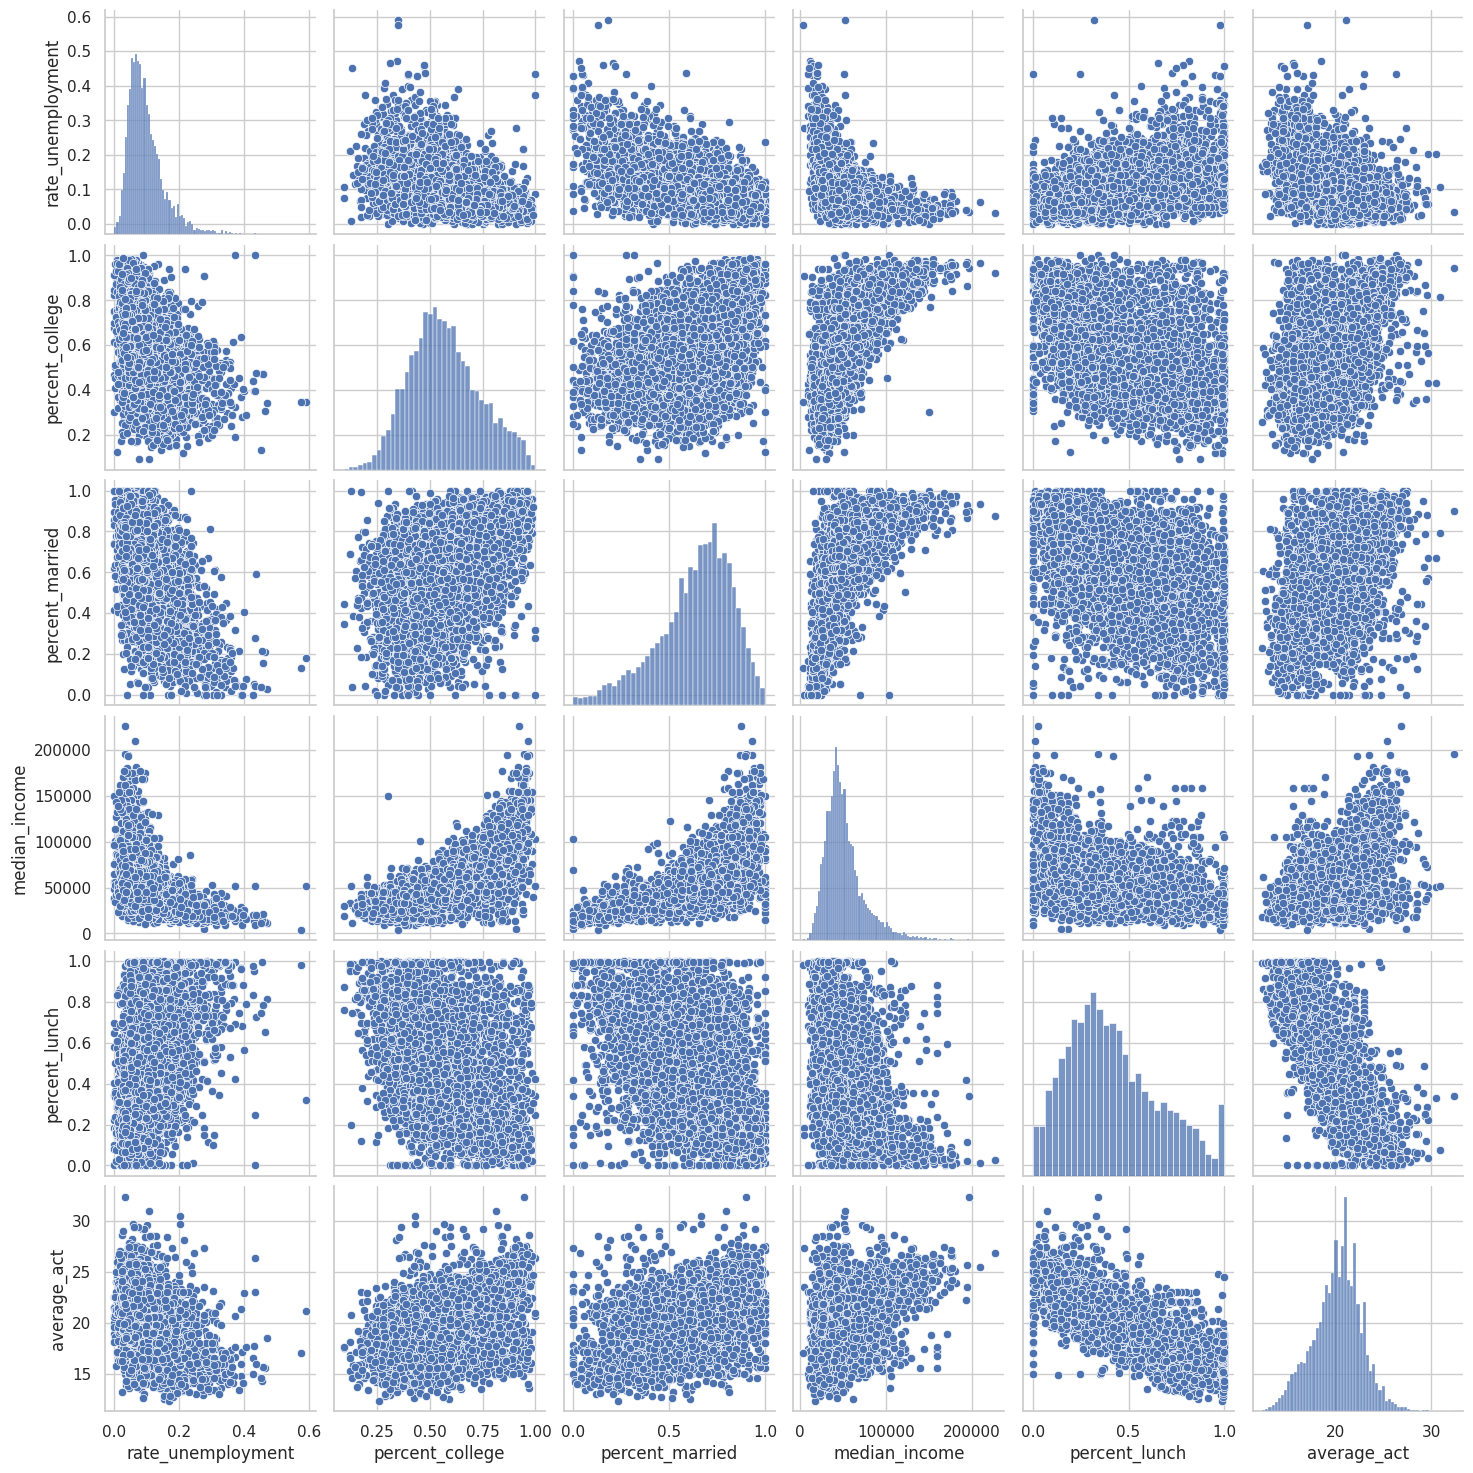

In [1234]:
df1 = geographic_df[['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'average_act']]
df2 = geographic_df[['state', 'school_type', 'school_level', 'state_population', 'zip_code', 'zip_first_two_digits', 'zip_first_two_digits_population', 'average_act']]
sns.pairplot(data = df1)

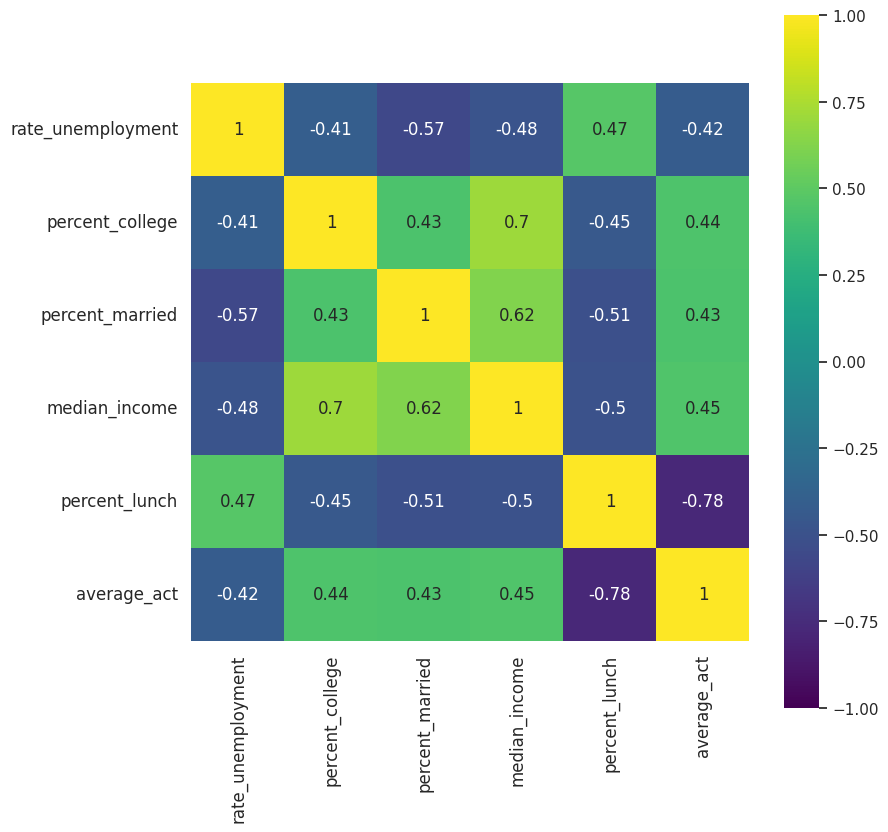

In [1235]:
corr_matrix_1 = df1.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr_matrix_1, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')
plt.tick_params(labelsize=12);

According to this correlation matrix, there is a fairly strong linear relationship between average_act and all of the socioeconomic variables. The correlation between percent_lunch and average_act is especially strong. So, linear regression would be a good technique for predicting the average ACT score from just those variables.

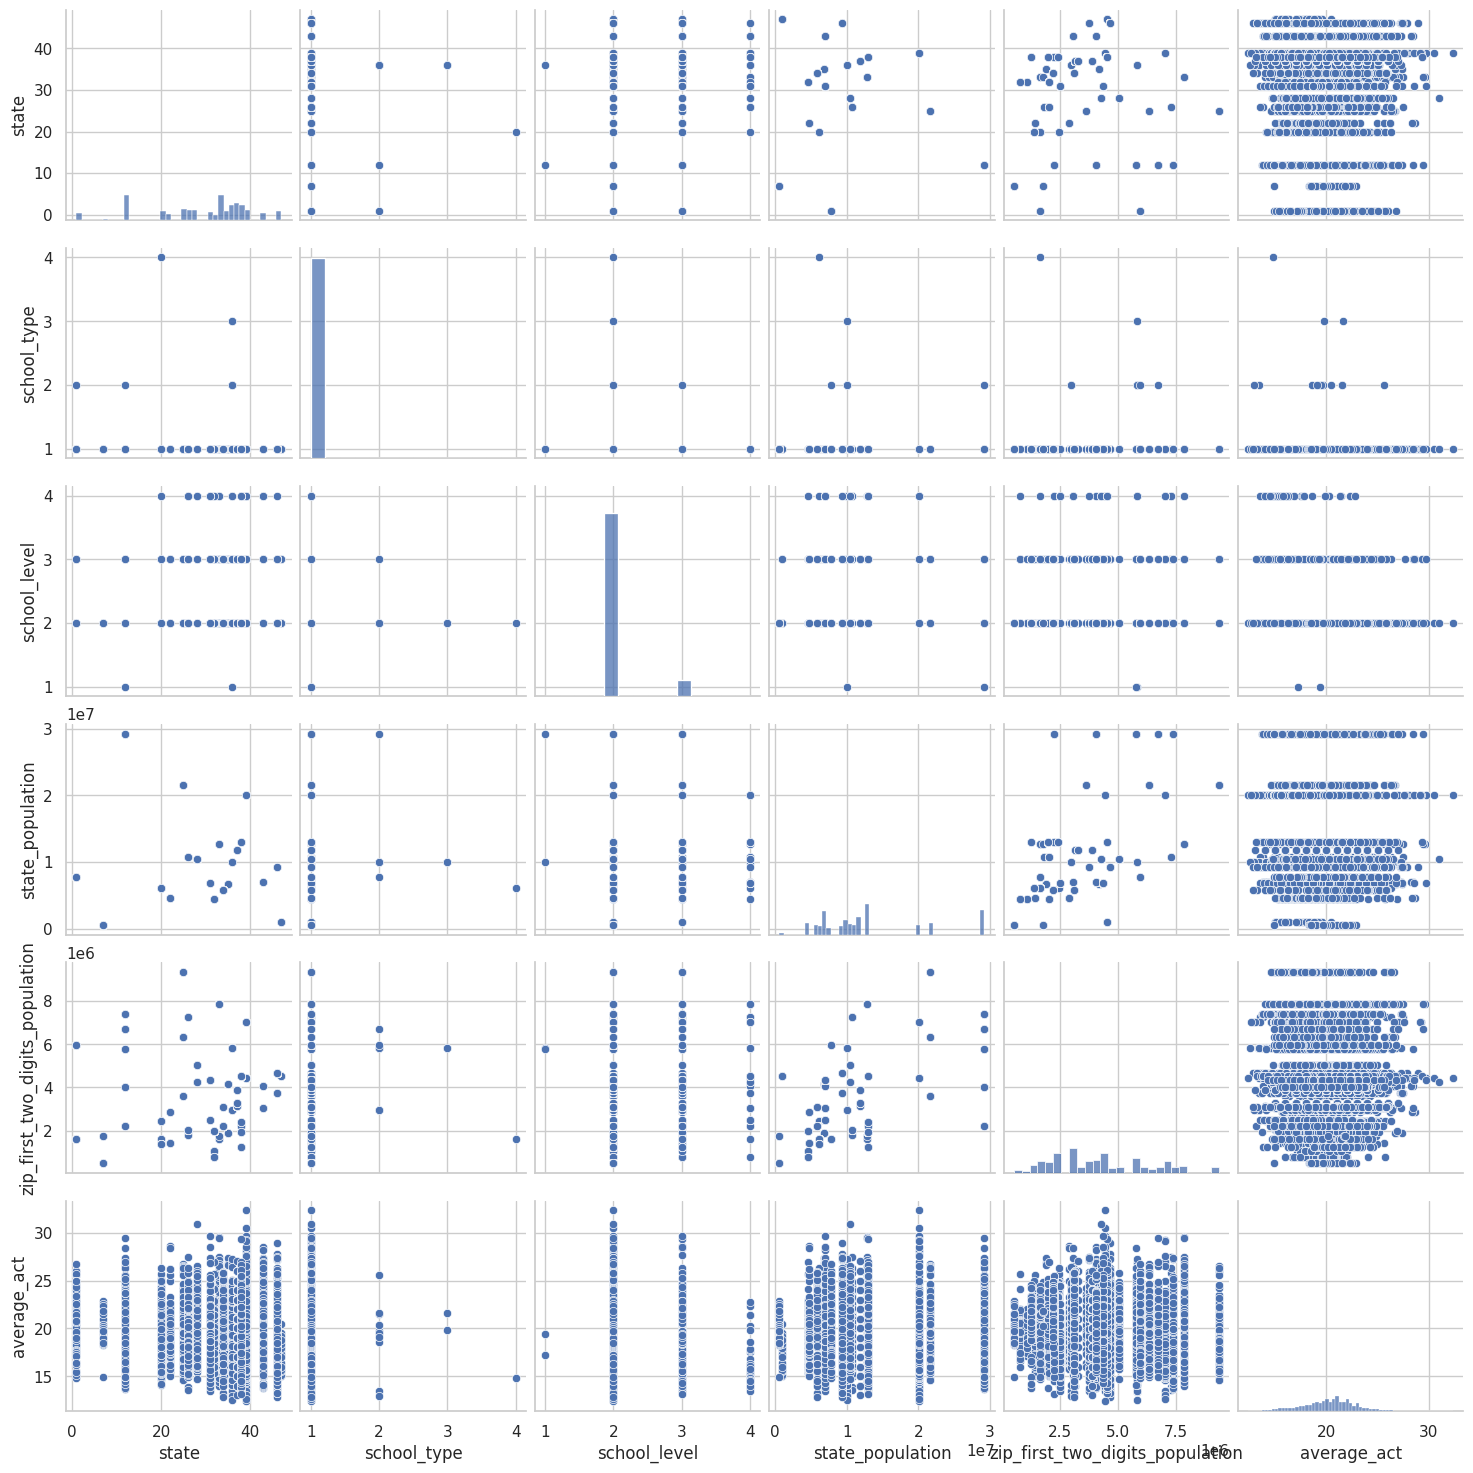

In [1236]:
sns.pairplot(data = df2)

This pairplot indicates almost no relationship between average_act and the other variables.

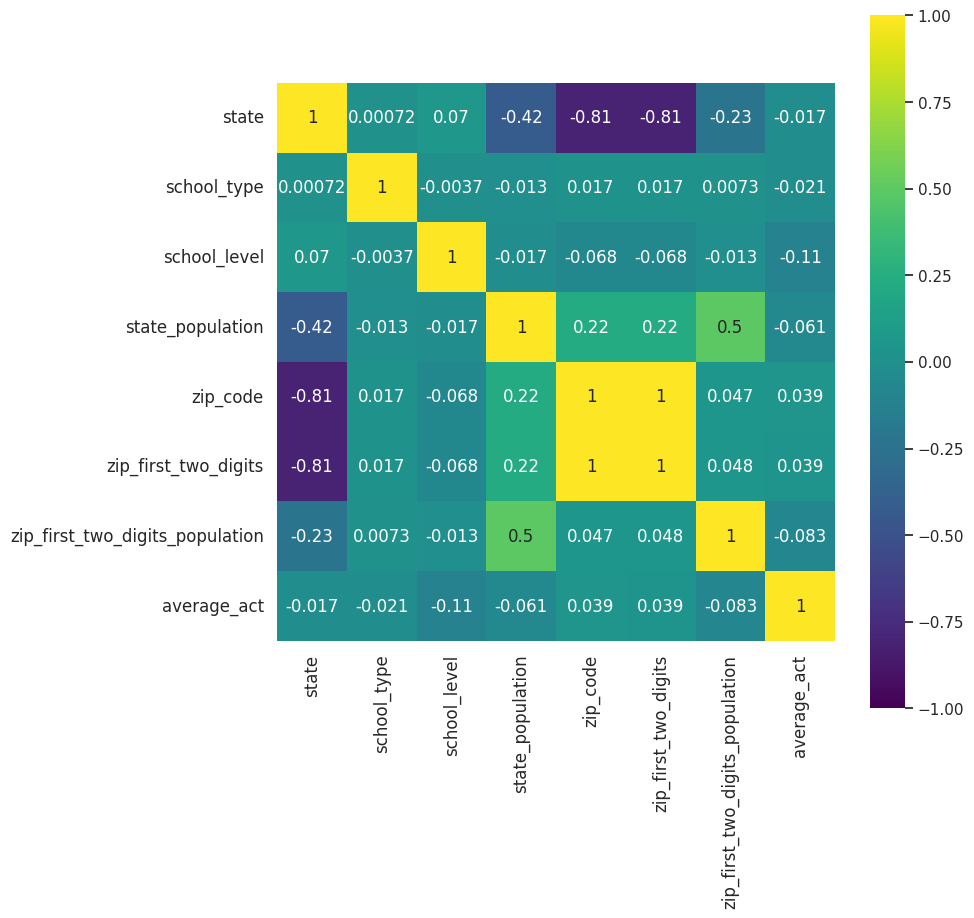

In [1237]:
corr_matrix_2 = df2.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr_matrix_2, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')
plt.tick_params(labelsize=12);

According to the correlation matrix above, the linear correlation between average_act and the other variables in that matrix is very low. That implies that there is not a linear relationship between the average ACT score and those variables. The pairplot indicates no relationship at all, not even a nonlinear one.

### Random forest

For the main analysis question, we will use first use random forest regression to predict the average ACT score.

#### Model selection

We will do a parameter sweep for the number of estimators and `min_samples_split`.

In [1149]:
# Defining our search space
n_estimator_values = [8, 16, 32, 64, 128]
min_samples_split_values = [2, 4, 8]

out = {} # output dictionary

# Training a model for each combination of n_estimators and min_samples_split
for n_estimators in n_estimator_values:
  for min_samples_split in min_samples_split_values:
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=0).fit(X_train_norm, Y_train)
    Y_pred_test = rf_reg.predict(X_test_norm)
    rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test)**2))
    out[(n_estimators, min_samples_split)] = rmse_test

In [1150]:
sorted_out = dict(sorted(out.items(), key=lambda item: item[1])) # Sort the dictionary by RMSE

for key, val in sorted_out.items():
  print(f"{key[0]} trees, {key[1]} min samples: rmse = {val}")

128 trees, 8 min samples: rmse = 1.377967933142067
128 trees, 4 min samples: rmse = 1.382868077621571
64 trees, 8 min samples: rmse = 1.385151402378793
128 trees, 2 min samples: rmse = 1.3856515385262542
32 trees, 8 min samples: rmse = 1.3930279832140113
64 trees, 4 min samples: rmse = 1.3942639010206235
64 trees, 2 min samples: rmse = 1.396516101419797
32 trees, 4 min samples: rmse = 1.4044441062491593
32 trees, 2 min samples: rmse = 1.404760166384518
16 trees, 8 min samples: rmse = 1.4142350837083404
16 trees, 2 min samples: rmse = 1.4275688738723613
16 trees, 4 min samples: rmse = 1.4299290853888749
8 trees, 8 min samples: rmse = 1.4445485295976608
8 trees, 4 min samples: rmse = 1.4607870775204632
8 trees, 2 min samples: rmse = 1.4623774550234936


The results of the parameter sweep are that the best number of estimators is 128 and the best number of minimum samples is 8. So, we will use those parameters for the regressor.

#### Fit the model and analyze the model results

We will fit the model and then plot the true ACT scores vs. the predicted ACT scores for both the training and testing sets. We will also calculate the root mean squared error for the training and test sets. These steps will tell us how well the model fits the data. That will help us see if there is a relationship between average ACT scores and socioeconomic factors. There are no units for ACT scores, but we will assume ACT scores are measured in points.

In [1238]:
rf_reg = RandomForestRegressor(random_state=0, bootstrap=True, n_estimators=128, min_samples_split=8).fit(X_train_norm, Y_train)
Y_pred_test = rf_reg.predict(X_test_norm)
Y_pred_train = rf_reg.predict(X_train_norm)

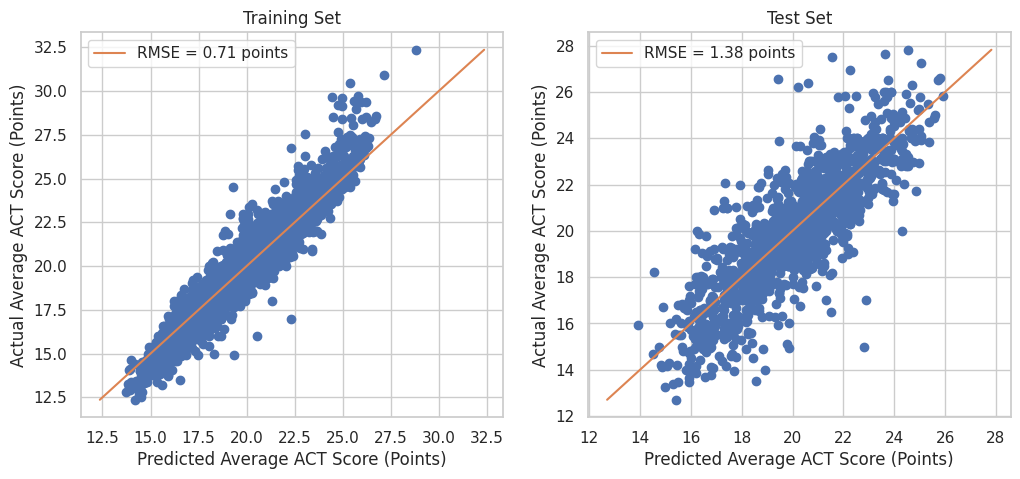

In [1239]:
one_train = np.linspace(Y_train.min(), Y_train.max(), 100)
one_test = np.linspace(Y_test.min(), Y_test.max(), 100)
rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test)**2))
rmse_train = np.sqrt(np.mean((Y_pred_train - Y_train)**2))

fig,(ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Y_pred_train, Y_train, 'o')
ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
ax1.set_title("Training Set")
ax1.set_xlabel("Predicted Average ACT Score (Points)")
ax1.set_ylabel("Actual Average ACT Score (Points)")
ax1.legend()

ax2.plot(Y_pred_test, Y_test, 'o')
ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} points")
ax2.legend()
ax2.set_title("Test Set")
ax2.set_xlabel("Predicted Average ACT Score (Points)")
ax2.set_ylabel("Actual Average ACT Score (Points)")
fig.set_size_inches(12, 5)

Let's find the range of ACT scores.

In [1240]:
print(Y_test.max(), Y_test.min(), Y_test.max() - Y_test.min())

27.8205128205128 12.7045177045177 15.1159951159951


The root mean squared error on the test set is 1.38 points. The ACT scores range from about 12.7 points to about 27.8 points, so the range of the ACT scores is about 15.1. Thus, the RMSE is small compared to the scale of the data. That means that our model fits the data well.

Now that we know our model is accurate, let's look at the feature importances.

In [1241]:
feature_importances = rf_reg.feature_importances_
feature_importances_df = pd.DataFrame(data=feature_importances.reshape((1,9)), columns=X_train_norm.columns)
feature_importances_df

state  zip_code  school_type  school_level  rate_unemployment  \
0  0.042095   0.05398     0.000332      0.005576           0.044832   

   percent_college  percent_married  median_income  percent_lunch  
0         0.080513         0.048824       0.039402       0.684446

`percent_lunch` is the most important feature by a large amount. The other features are not nearly as important for predicting ACT scores. That tells us that there is a strong relationship between ACT scores and the percentage of students who qualify for free or reduced lunch. However, the relationship between ACT scores and the other socioeconomic variables is much weaker.

### Multiple linear regression

Now, we will fit a multiple linear regression model to answer the main analysis question. This will help us see how a unit change in each feature $x_i$ changes the average ACT score.

In [1155]:
lin_reg = LinearRegression().fit(X_train_norm, Y_train)
Y_pred_test = lin_reg.predict(X_test_norm)
Y_pred_train = lin_reg.predict(X_train_norm)

To evaluate how well the linear model fits the data, let's find the root mean squared error and plot the actual vs. predicted ACT scores for both the training and testing sets.

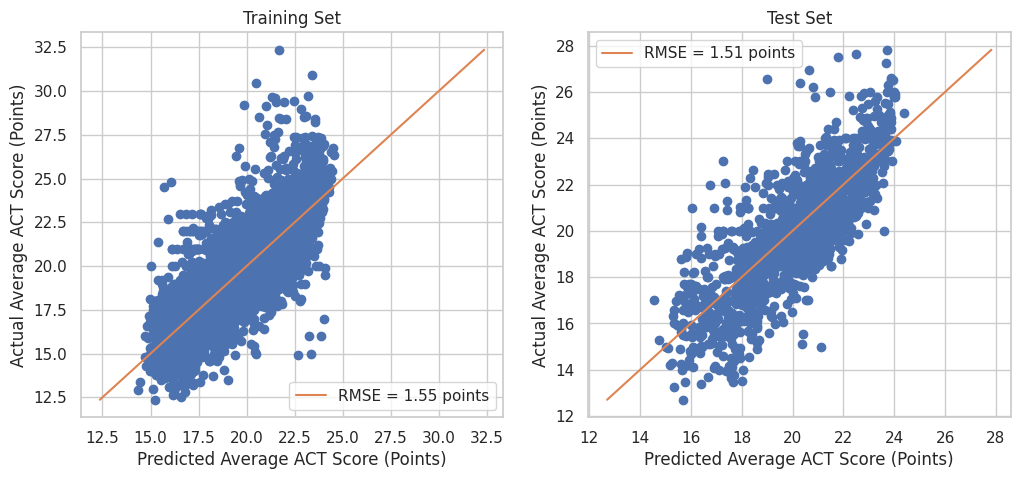

In [1156]:
one_train = np.linspace(Y_train.min(), Y_train.max(), 100)
one_test = np.linspace(Y_test.min(), Y_test.max(), 100)
rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test)**2))
rmse_train = np.sqrt(np.mean((Y_pred_train - Y_train)**2))

fig,(ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Y_pred_train, Y_train, 'o')
ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
ax1.set_title("Training Set")
ax1.set_xlabel("Predicted Average ACT Score (Points)")
ax1.set_ylabel("Actual Average ACT Score (Points)")
ax1.legend()

ax2.plot(Y_pred_test, Y_test, 'o')
ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} points")
ax2.legend()
ax2.set_title("Test Set")
ax2.set_xlabel("Predicted Average ACT Score (Points)")
ax2.set_ylabel("Actual Average ACT Score (Points)")
fig.set_size_inches(12, 5)

The RMSE on the test set is only 1.51 points, which is again small compared to the range of the ACT scores. So, our linear model fits the data well.

Now, let's get the coefficients of the linear regression problem to see which features cause the greatest change in ACT scores.

In [1157]:
coefficients_df = pd.DataFrame(data=lin_reg.coef_.reshape((1,9)), columns=X_train_norm.columns)
coefficients_df

state  zip_code  school_type  school_level  rate_unemployment  \
0 -0.027643 -0.000007    -0.645468     -0.055407          -0.095871   

   percent_college  percent_married  median_income  percent_lunch  
0         0.284458        -0.021486       0.019215      -1.823338

The coefficient $\beta_i$ can be interpreted as the change in the target $Y$ due to a one-unit increase in the feature $X_i$.

`percent_lunch` has the largest-magnitude coefficient by a large amount (-1.82). So, again, `percent_lunch` has the largest effect on ACT scores. When the percentage of students who qualify for free or reduced lunch increases by only 1%, the average ACT score decreases by 1.82 points. That is a large decrease considering the range of the `percent_lunch` and `average_act` variables.

`school_type` has the coefficient with the second-largest magnitude. Its coefficient is -0.645. This is harder to interpret since it's a categorical variable. The school types are 1: Regular School, 2: Alternative School, 3: Career and Technical School, and 4: Special Education School. When we increase `school_type` by 1, then on average, the ACT score decreases by 0.645. But that is an average, so we do not know how each individual increase in `school_type` from 1 to 4 changes the predicted ACT score.

`percent_college` also has a coefficient that is fairly large in magnitude (0.28). When the percentage of students whose parents have college degrees increases by 1%, the average ACT score increases by 0.28. The effect of `percent_college` on ACT scores is not as large as the effect of `percent_lunch`, but it is still significant.

So, two of the socioeconomic variables, `percent_lunch` and `percent_college` do have a relationship with average ACT scores. For the other socioeconomic variables, there is almost no linear relationship since the coefficients are so small.

## Additional Step Analysis

Let's answer the geographic data question now: What is the relationship between geographic location and ACT scores?

Since the correlation matrix indicated no linear relationship between the geographic predictors and the ACT scores, we will not use linear regression. We will only use random forest.

Again, we will do a parameter sweep for the number of trees and `min_samples_split`.

In [1158]:
# Defining our search space
n_estimator_values = [8, 16, 32, 64, 128]
min_samples_split_values = [2, 4, 8]

# Setting up an output dictionary
out = {}

# Training a model for each combo (5 * 3 = 15 models)
for n_estimators in n_estimator_values:
  for min_samples_split in min_samples_split_values:
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, random_state=0).fit(X_train_geographic_norm, Y_train_geographic)
    Y_pred_test = rf_reg.predict(X_test_geographic_norm)
    rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test_geographic)**2))
    out[(n_estimators, min_samples_split)] = rmse_test

In [1075]:
sorted_out = dict(sorted(out.items(), key=lambda item: item[1])) # Sort the dictionary by RMSE

for key, val in sorted_out.items():
  print(f"{key[0]} trees, {key[1]} min samples: rmse = {val}")

128 trees, 8 min samples: rmse = 1.3359335606493414
128 trees, 4 min samples: rmse = 1.3393283948541872
64 trees, 8 min samples: rmse = 1.343900126862365
128 trees, 2 min samples: rmse = 1.344687450950326
32 trees, 8 min samples: rmse = 1.3491005046217113
64 trees, 4 min samples: rmse = 1.3495299442146613
64 trees, 2 min samples: rmse = 1.3517088218109614
32 trees, 4 min samples: rmse = 1.352137285124928
32 trees, 2 min samples: rmse = 1.3544566814542343
16 trees, 8 min samples: rmse = 1.369933232613712
16 trees, 4 min samples: rmse = 1.3789388905171116
16 trees, 2 min samples: rmse = 1.383638783256795
8 trees, 8 min samples: rmse = 1.4069215120950462
8 trees, 4 min samples: rmse = 1.4231025664749142
8 trees, 2 min samples: rmse = 1.4424510616776134


The best parameter values are 128 trees and 8 minimum samples. Let's fit the model with those parameters. Then let's plot the actual vs. predicted ACT scores and calculate the RMSE for the training and testing sets.

In [1163]:
rf_reg = RandomForestRegressor(random_state=0, bootstrap=True, n_estimators=128, min_samples_split=8).fit(X_train_geographic_norm, Y_train)
Y_pred_test = rf_reg.predict(X_test_geographic_norm)
Y_pred_train = rf_reg.predict(X_train_geographic_norm)

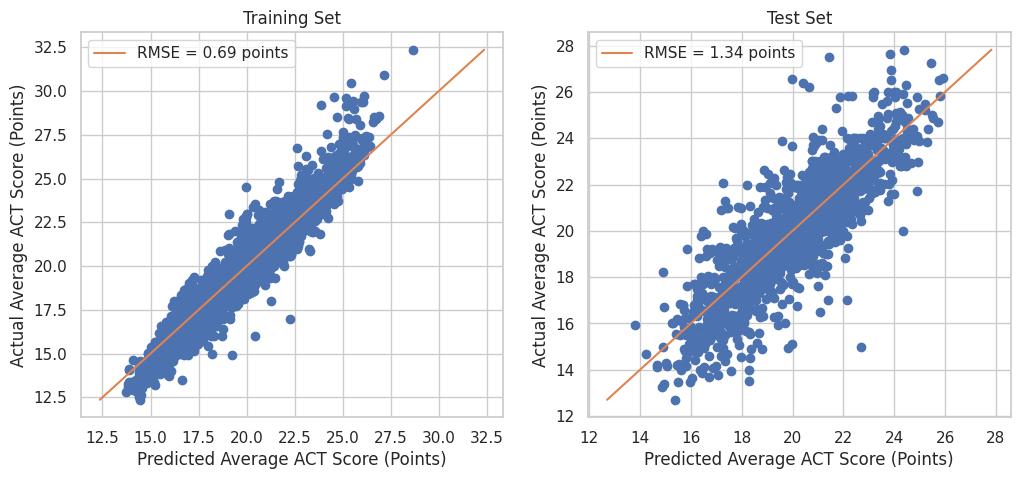

In [1164]:
one_train = np.linspace(Y_train_geographic.min(), Y_train_geographic.max(), 100)
one_test = np.linspace(Y_test_geographic.min(), Y_test_geographic.max(), 100)
rmse_test = np.sqrt(np.mean((Y_pred_test - Y_test)**2))
rmse_train = np.sqrt(np.mean((Y_pred_train - Y_train)**2))

fig,(ax1, ax2) = plt.subplots(1, 2)
ax1.plot(Y_pred_train, Y_train, 'o')
ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
ax1.set_title("Training Set")
ax1.set_xlabel("Predicted Average ACT Score (Points)")
ax1.set_ylabel("Actual Average ACT Score (Points)")
ax1.legend()

ax2.plot(Y_pred_test, Y_test, 'o')
ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} points")
ax2.legend()
ax2.set_title("Test Set")
ax2.set_xlabel("Predicted Average ACT Score (Points)")
ax2.set_ylabel("Actual Average ACT Score (Points)")
fig.set_size_inches(12, 5)

The model fits the data well since an RMSE of 1.34 points is small compared to the range of ACT scores. Now let's find the feature importances to see whether the geographic features are important when predicting ACT scores.

In [1169]:
feature_importances = rf_reg.feature_importances_
feature_importances_df = pd.DataFrame(data=feature_importances.reshape((1,12)), columns=X_train_geographic_norm.columns)
feature_importances_df

state  zip_code  zip_first_two_digits  school_type  school_level  \
0  0.02078  0.040038              0.006721     0.000227      0.005302   

   rate_unemployment  percent_college  percent_married  median_income  \
0           0.039032          0.07786         0.044383       0.036117   

   percent_lunch  state_population  zip_first_two_digits_population  
0       0.678086           0.02961                         0.021844

Even though we added geographic predictors, percent_lunch still has a very high feature importance compared to the other variables. The geographic predictors (zip_code, zip_first_two_digits, state, and the populations) have very low feature importances. That means there is no relationship between geographic location and ACT scores.

## Conclusion

Provide a brief description of your conclusions.

There is a relationship between ACT scores and some socioeconomic variables but not others. The socioeconomic variable that influences ACT scores the most is the percentage of students who qualify for free or reduced lunch. Based on the linear regression model, when that percentage increases by 1%, the average ACT scores decrease by 1.28 points. Because the range of ACT scores is up to 36, that is a large decrease.

The percentage of students whose parents have college degrees also influences the ACT scores, but not as much as the variable described above. Specifically, when that percentage increases by 1%, the average ACT score increases by 0.28 points. However, there was no relationship between average ACT scores and any of the other socioeconomic variables.

Furthermore, there is no relationship between geographic location and average ACT scores. The predictors related to geographic location were state, state population, zip code, the first two digits of the zip code, and the total population for those first two digits. In the random forest regressor, all of those predictors had a feature importance of almost zero.